In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/sample.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv


# 1.)LIBRARIES

In [15]:
import pandas as pd
import numpy as np

import datetime

import re

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import cross_val_score,validation_curve

# 2.)LOADING_DATASETS


In [4]:
train=pd.read_csv('/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv')

In [5]:
test=pd.read_csv('/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv')

In [5]:
train.shape

(13636, 15)

Here we can see around 13600 rows and 14 features and 1 target variable which is Ratings 

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13636 entries, 0 to 13635
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 13636 non-null  int64 
 1   RecipeNumber       13636 non-null  int64 
 2   RecipeCode         13636 non-null  int64 
 3   RecipeName         13636 non-null  object
 4   CommentID          13636 non-null  object
 5   UserID             13636 non-null  object
 6   UserName           13636 non-null  object
 7   UserReputation     13636 non-null  int64 
 8   CreationTimestamp  13636 non-null  int64 
 9   ReplyCount         13636 non-null  int64 
 10  ThumbsUpCount      13636 non-null  int64 
 11  ThumbsDownCount    13636 non-null  int64 
 12  Rating             13636 non-null  int64 
 13  BestScore          13636 non-null  int64 
 14  Recipe_Review      13634 non-null  object
dtypes: int64(10), object(5)
memory usage: 1.6+ MB


# **Exploratory Data Analysis**

Checking for missing values,impute/drop them 

In [6]:
train.isnull().sum()

ID                   0
RecipeNumber         0
RecipeCode           0
RecipeName           0
CommentID            0
UserID               0
UserName             0
UserReputation       0
CreationTimestamp    0
ReplyCount           0
ThumbsUpCount        0
ThumbsDownCount      0
Rating               0
BestScore            0
Recipe_Review        2
dtype: int64

We got only two missing values in the Recipe_Review feature lets drop it

In [7]:
train.dropna(inplace=True)

In [8]:
train.select_dtypes(include=['object']).columns.tolist()

['RecipeName', 'CommentID', 'UserID', 'UserName', 'Recipe_Review']

We got **5** Features as **Categorical** data type 

In [9]:
train.select_dtypes(include=['int64']).columns.tolist()

['ID',
 'RecipeNumber',
 'RecipeCode',
 'UserReputation',
 'CreationTimestamp',
 'ReplyCount',
 'ThumbsUpCount',
 'ThumbsDownCount',
 'Rating',
 'BestScore']

We got **9** Features as **Numeric** data type 

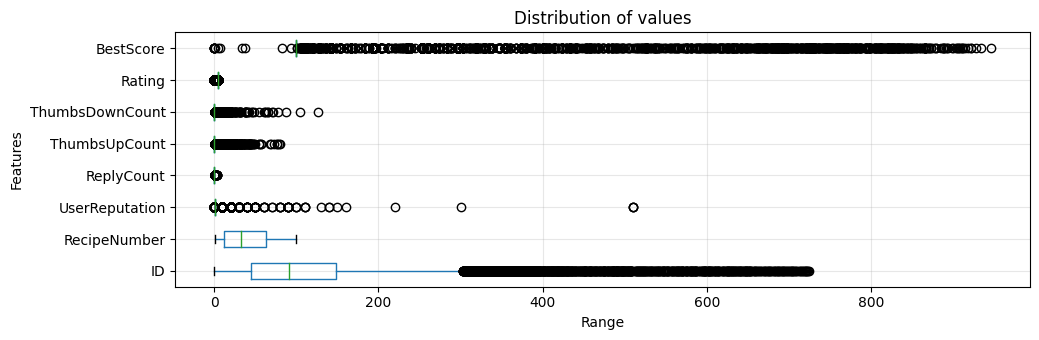

In [10]:
plt.rcParams["figure.figsize"] = [10.50, 3.50]
plt.rcParams["figure.autolayout"] = True
train[['ID','RecipeNumber','UserReputation','ReplyCount','ThumbsUpCount','ThumbsDownCount','Rating','BestScore']].boxplot(vert=False)
plt.xlabel('Range')
plt.ylabel('Features')
plt.title('Distribution of values')
plt.grid(alpha=0.3)
plt.show()

From this box plot we can see that we got more number of outliers in our dataset we need apply proper scaling method in preprocessing in order to tackel this dataset 

ID 2.1455283953188893


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


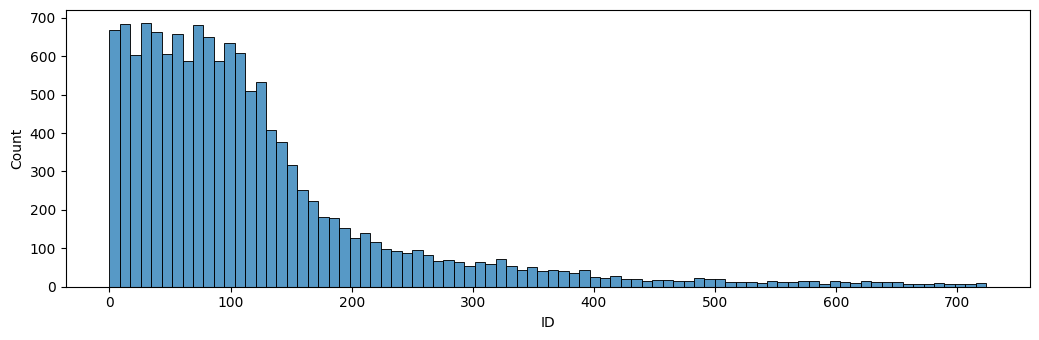

RecipeNumber 0.4633561651671538


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


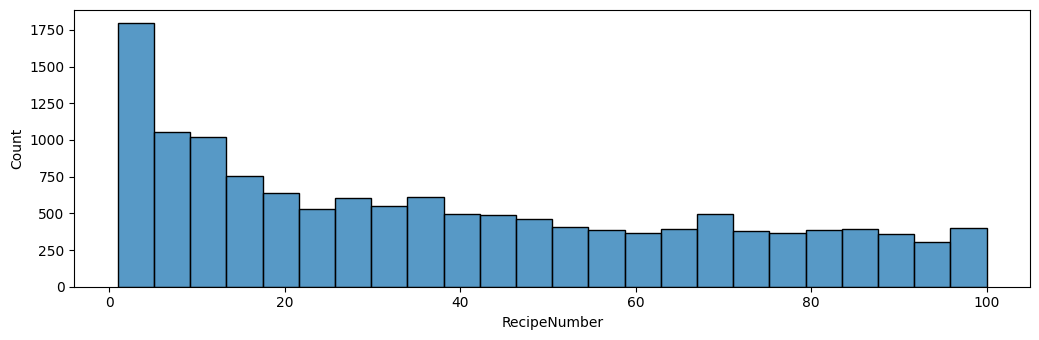

RecipeCode 3.451628274561243


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


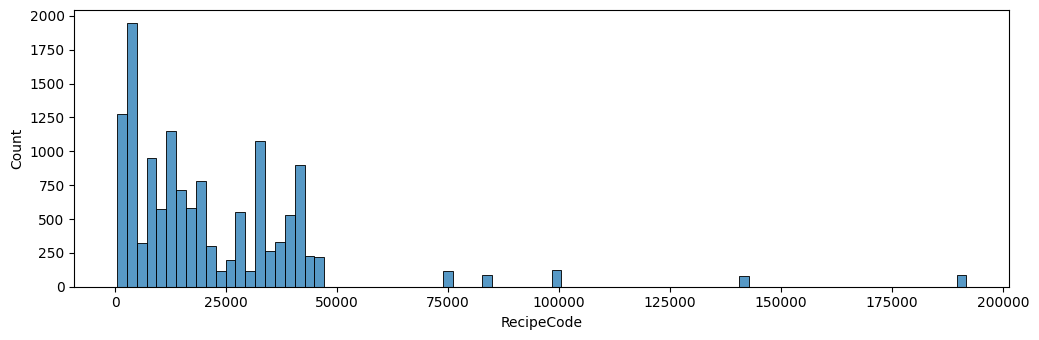

UserReputation 33.145629078316894


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


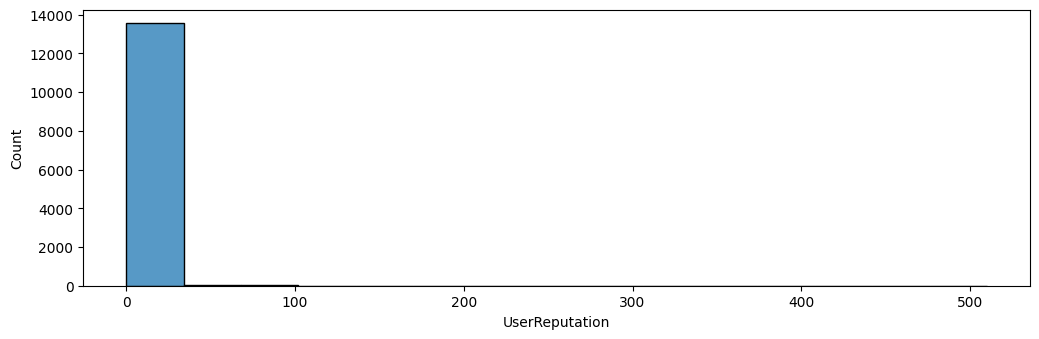

ReplyCount 11.406130048501064


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


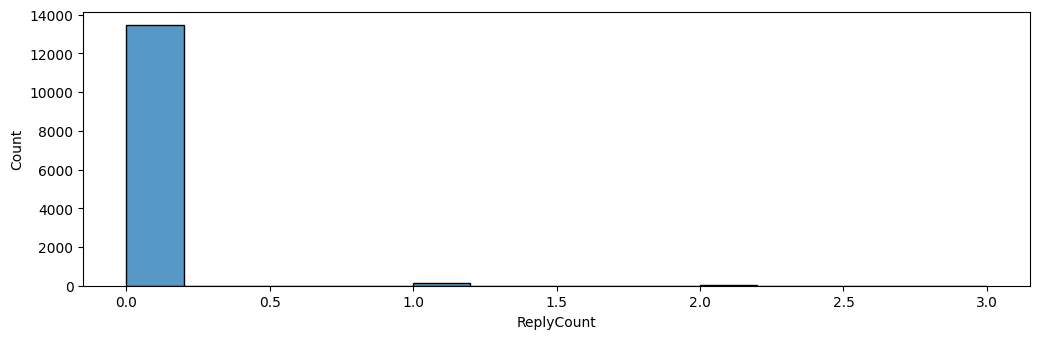

ThumbsUpCount 7.884708062150054


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


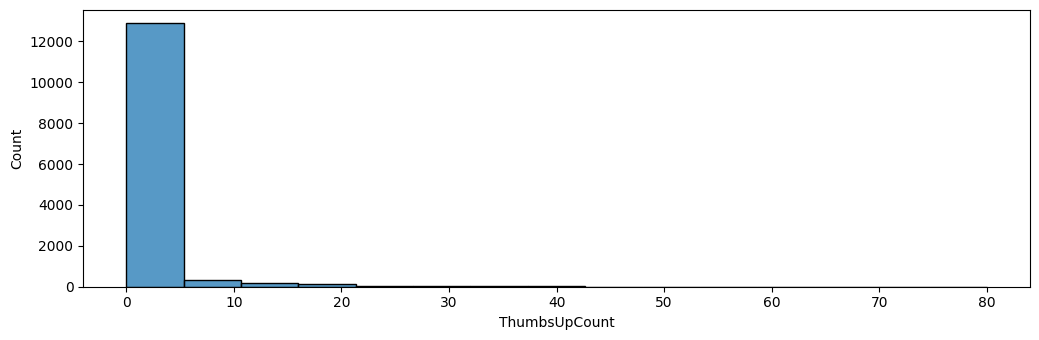

ThumbsDownCount 16.65707172820137


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


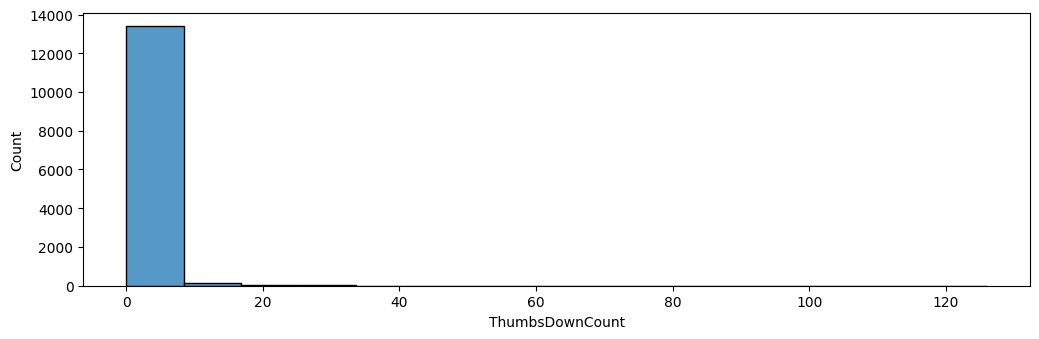

BestScore 3.3925176201959526


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


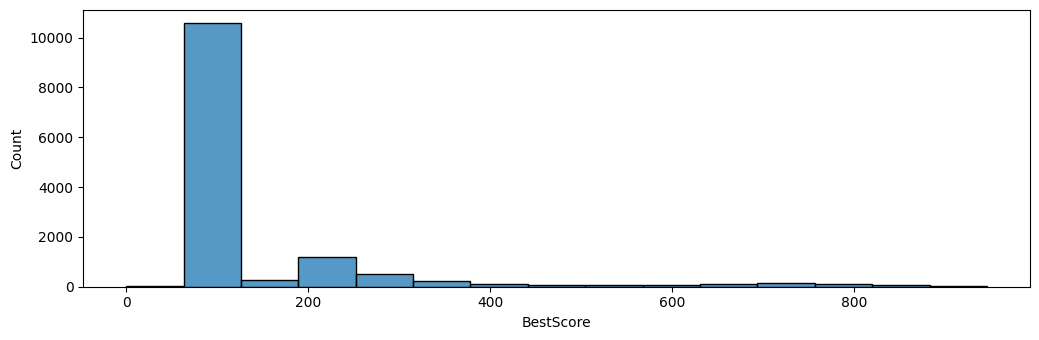

Rating -2.1279688003355854


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


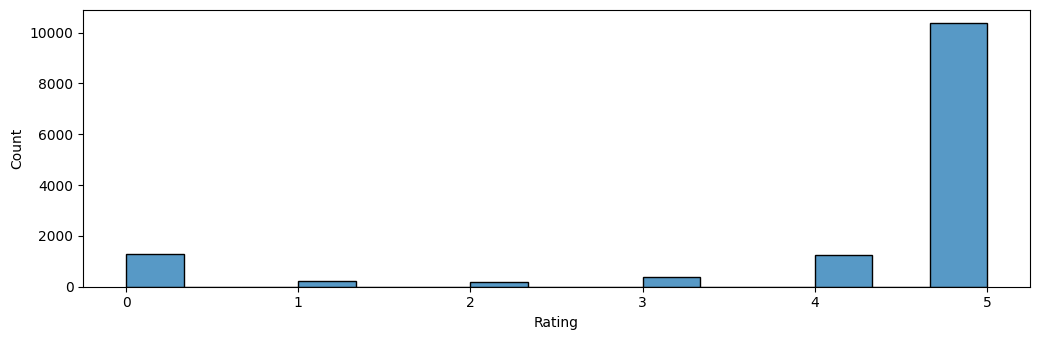

In [27]:
l=['ID','RecipeNumber','RecipeCode','UserReputation','ReplyCount','ThumbsUpCount','ThumbsDownCount','BestScore','Rating']

for x in l:
    print(x,skew(train[x]))
    plt.figure()
    sns.histplot(train[x])
    plt.show()

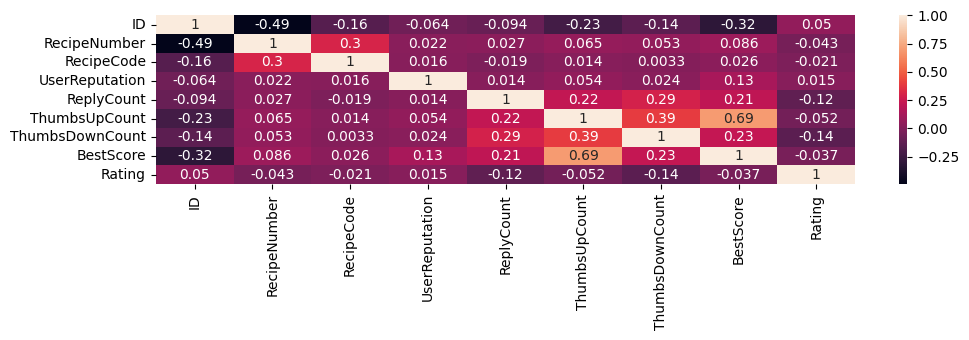

In [22]:
plt.figure()
sns.heatmap(train[l].corr(),annot=True)
plt.show()

ID 2.1455283953188893


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


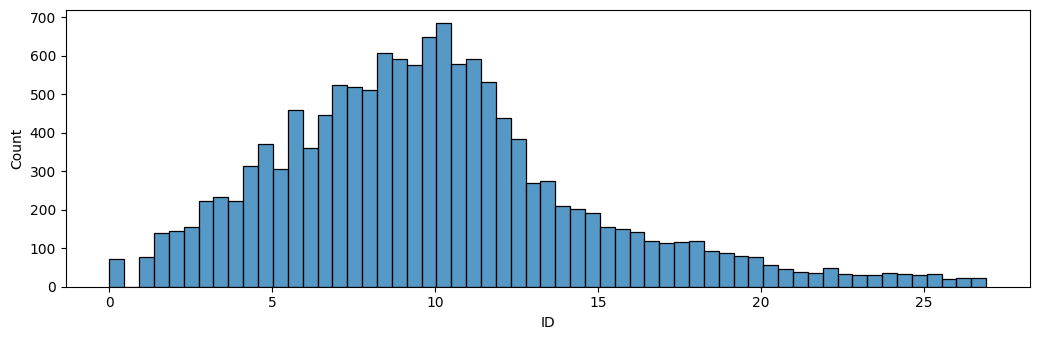

RecipeNumber 0.4633561651671538


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


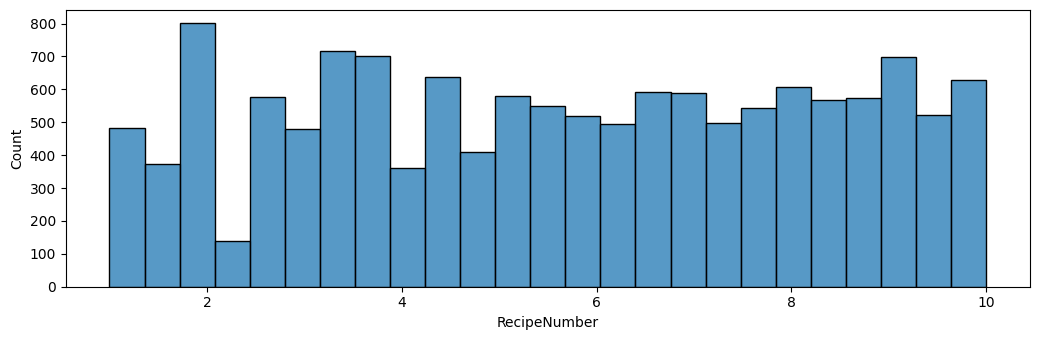

RecipeCode 3.451628274561243


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


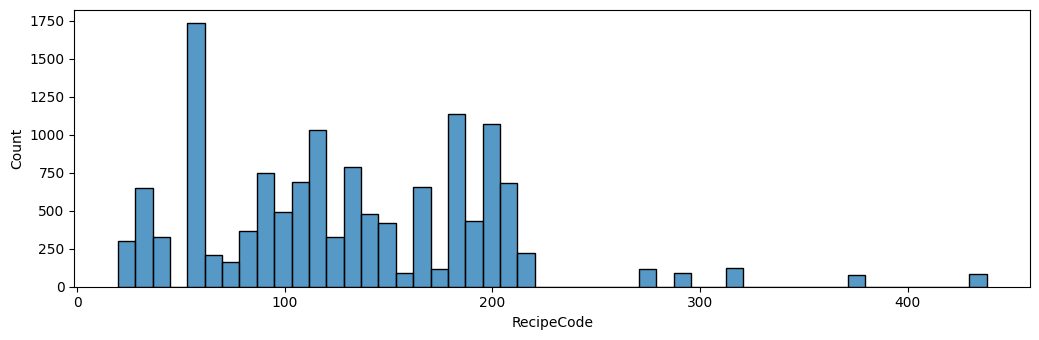

UserReputation 33.145629078316894


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


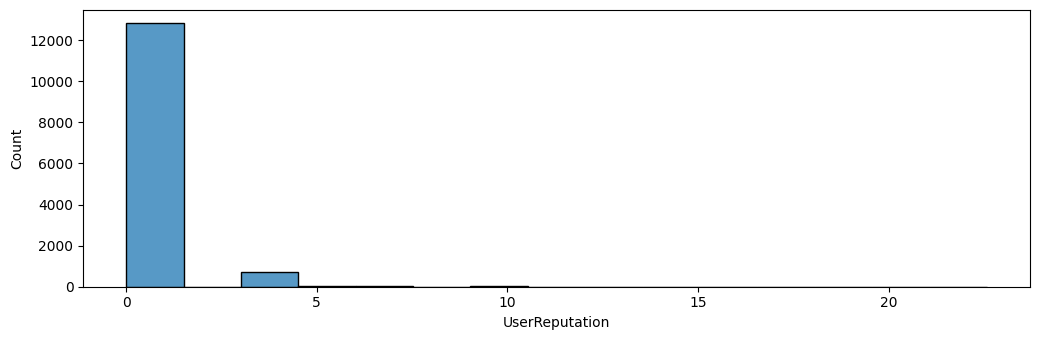

ReplyCount 11.406130048501064


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


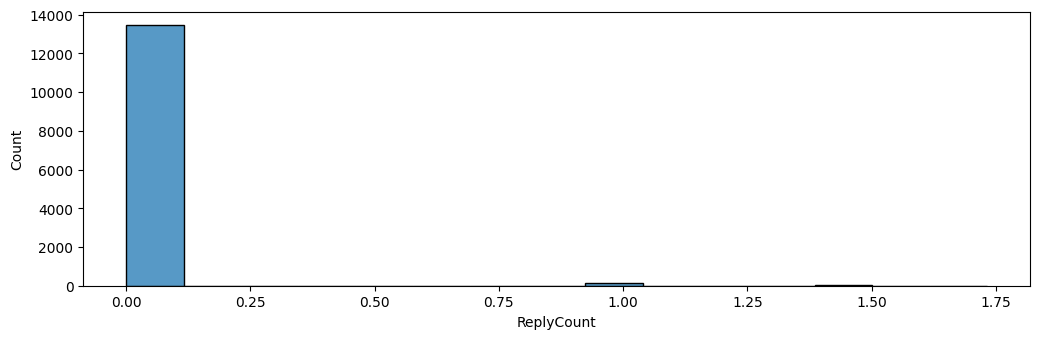

ThumbsUpCount 7.884708062150054


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


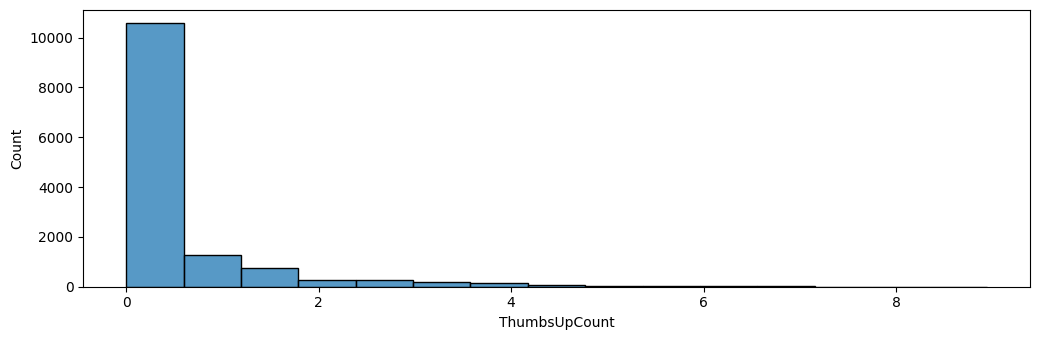

ThumbsDownCount 16.65707172820137


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


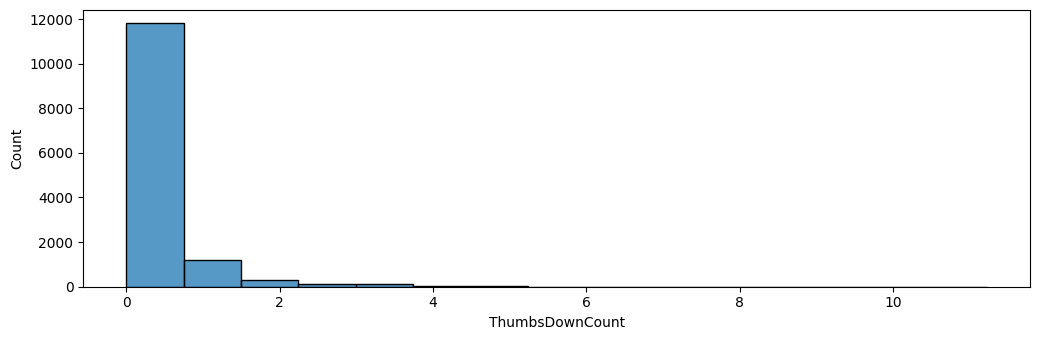

BestScore 3.3925176201959526


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


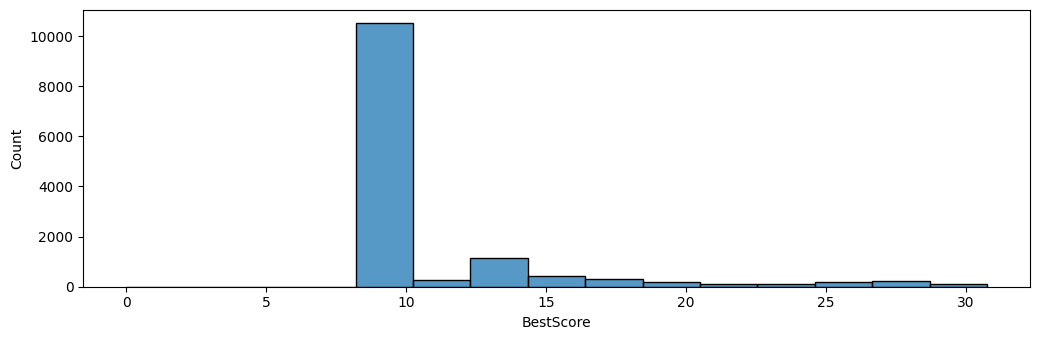

Rating -2.1279688003355854


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


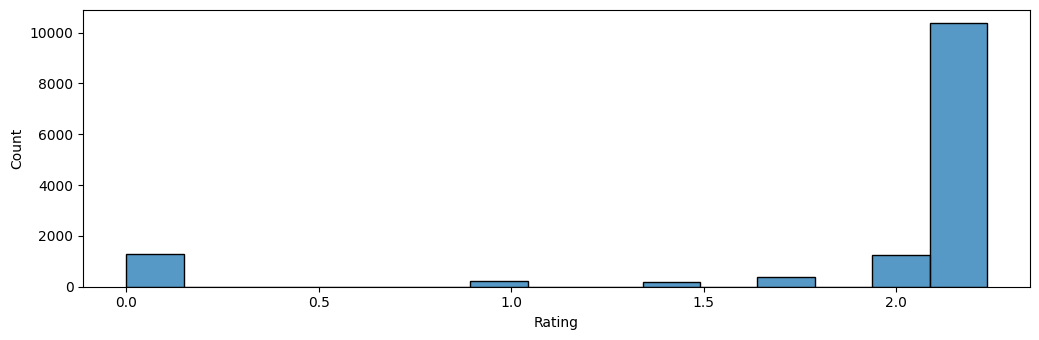

In [24]:
for x in l:
    print(x,skew(train[x]))
    plt.figure()
    sns.histplot(np.sqrt(train[x]))
    plt.show()

**Categorizing food items**(
Getting all unique recipe names)

In [54]:
train['RecipeName'].unique()

array(['Banana Bars with Cream Cheese Frosting', 'Simple Taco Soup',
       'Cheeseburger Soup', 'Grilled Huli Huli Chicken',
       'Cauliflower Soup', 'Favorite Chicken Potpie',
       'Fluffy Key Lime Pie', 'Seafood Lasagna', 'Cheesy Ham Chowder',
       'First-Place Coconut Macaroons', 'Rhubarb Custard Bars',
       'Garlic Beef Enchiladas', 'Pork Chops with Scalloped Potatoes',
       'Peanut Butter Cup Cheesecake', 'Li’l Cheddar Meat Loaves',
       'Chicken Wild Rice Soup', 'Flavorful Chicken Fajitas',
       'Enchilada Casser-Ole!', 'Creamy White Chili',
       'Stuffed Pepper Soup', 'Lemon Blueberry Bread',
       'Chicken and Dumplings', 'Porcupine Meatballs',
       'Simple Au Gratin Potatoes', 'Basic Homemade Bread',
       'Zucchini Cupcake', 'Forgotten Jambalaya', 'Ravioli Lasagna',
       'Contest-Winning New England Clam Chowder', 'Basic Banana Muffins',
       'Creamy Grape Salad', 'Big Soft Ginger Cookies',
       'Pumpkin Spice Cupcakes with Cream Cheese Frosting',
 

Categorizing the recipe names

In [55]:
recipes_dict = {
    'Breakfast': [
        'Amish Breakfast Casserole',
        'Blueberry French Toast',
        'Brown Sugar Oatmeal Pancakes',
        'Creamy Macaroni and Cheese',
        'Easy Chicken Enchiladas',
        'Fluffy Pancakes',
        'Basic Homemade Bread',
        'Best Ever Banana Bread'
    ],
    'Lunch': [
        'Bacon Macaroni Salad',
        'Black Bean ‘n’ Pumpkin Chili',
        'Bruschetta Chicken',
        'Buttery Cornbread',
        'Cauliflower Soup',
        'Best Ever Potato Soup',
        'Cheeseburger Paradise Soup',
        'Cheeseburger Soup',
        'Cheesy Ham Chowder',
        'Chicken Wild Rice Soup',
        'Chicken and Dumplings',
        'Comforting Chicken Noodle Soup',
        'Contest-Winning New England Clam Chowder',
        'Corn Pudding',
        'Creamy Coleslaw',
        'Creamy Grape Salad',
        'Creamy White Chili',
        'Egg Roll Noodle Bowl',
        'Enchilada Casser-Ole!',
        'Favorite Chicken Potpie',
        'First-Place Coconut Macaroons',
        'Forgotten Jambalaya',
        'Garlic Beef Enchiladas',
        'Gluten-Free Banana Bread',
        'Homemade Peanut Butter Cups',
        'Hot Milk Cake',
        'Li’l Cheddar Meat Loaves',
        'Macaroni Coleslaw',
        'Quick Cream of Mushroom Soup',
        'Ravioli Lasagna',
        'Rhubarb Custard Bars',
        'Rustic Italian Tortellini Soup',
        'Simple Au Gratin Potatoes',
        'Simple Taco Soup',
        'Skillet Shepherd’s Pie',
        'Smothered Chicken Breasts',
        'Stuffed Pepper Soup',
        'Vegetarian Linguine',
        'White Bean Chicken Chili',
        'Zucchini Pizza Casserole'
    ],
    'Dinner': [
        'Asian Chicken Thighs',
        'Baked Mushroom Chicken',
        'Baked Spaghetti',
        'Baked Tilapia',
        'Bruschetta Chicken',
        'Caramel-Pecan Cheesecake Pie',
        'Chicken Penne Casserole',
        'Flavorful Chicken Fajitas',
        'Flavorful Pot Roast',
        'Grilled Huli Huli Chicken',
        'Ham and Swiss Sliders',
        'Lime Chicken Tacos',
        'Mom’s Meat Loaf',
        'Pork Chops with Scalloped Potatoes',
        'Porcupine Meatballs',
        'Seafood Lasagna',
        'Shrimp Scampi',
        'Slow-Cooker Lasagna',
        'Teriyaki Chicken Thighs',
        'Traditional Lasagna',
        'Taco Lasagna',
        'Twice-Baked Potato Casserole'
    ],
    'Dessert': [
        'Apple Pie',
        'Banana Bars with Cream Cheese Frosting',
        'Big Soft Ginger Cookies',
        'Caramel Heavenlies',
        'Chunky Apple Cake',
        'Cherry Bars',
        'Chocolate Caramel Candy',
        'Chocolate Chip Oatmeal Cookies',
        'Chocolate Guinness Cake',
        'Chocolate-Strawberry Celebration Cake',
        'Easy Peanut Butter Fudge',
        'Fluffy Key Lime Pie',
        'Frosted Banana Bars',
        'Lemon Blueberry Bread',
        'Mamaw Emily’s Strawberry Cake',
        'Moist Chocolate Cake',
        'Peanut Butter Chocolate Dessert',
        'Peanut Butter Cup Cheesecake',
        'Pineapple Orange Cake',
        'Pineapple Pudding Cake',
        'Pumpkin Bars',
        'Pumpkin Bread',
        'Pumpkin Spice Cupcakes with Cream Cheese Frosting',
        'Sandy’s Chocolate Cake',
        'Special Banana Nut Bread',
        'Strawberry Pretzel Salad',
        'Tennessee Peach Pudding',
        'Winning Apple Crisp',
        'Zucchini Cupcake',
        'Basic Banana Muffins',
        'Favorite Dutch Apple Pie'
    ]
}


In [56]:
train['Category'] = train['RecipeName'].apply(lambda x: next((category for category, items in recipes_dict.items() if x in items), None))
test['Category'] = test['RecipeName'].apply(lambda x: next((category for category, items in recipes_dict.items() if x in items), None))

Categorised food items as Breakfast,Lunch,Dinner,Dessert and created new feature named Category

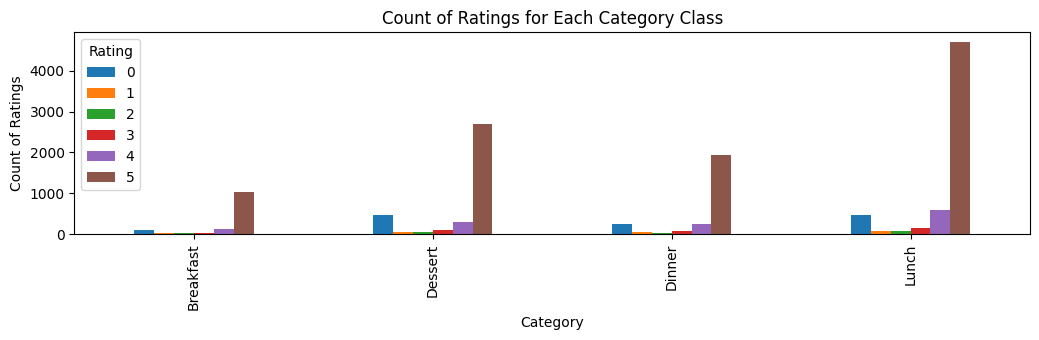

In [57]:
pivot_table = train.pivot_table(index='Category', columns='Rating', aggfunc='size', fill_value=0)
pivot_table.plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Count of Ratings')
plt.title('Count of Ratings for Each Category Class')
plt.show()

Finding Relation between Category and Ratings,
Users tends to give more ratings for **lunch** when compared to others

Binning Time

In [58]:
def convert_to_24hr_and_bin(timestamp):
    dt_object = datetime.datetime.fromtimestamp(timestamp)
    time_24hr = dt_object.strftime("%H:%M:%S")
    if dt_object.hour < 6:
        bin_label = 'night'
    elif dt_object.hour < 12:
        bin_label = 'morning'
    elif dt_object.hour < 18:
        bin_label = 'noon'
    else:
        bin_label = 'evening'

    return time_24hr, bin_label

train['Time'] = train['CreationTimestamp'].apply(lambda x: convert_to_24hr_and_bin(x)[1])
test['Time'] = test['CreationTimestamp'].apply(lambda x: convert_to_24hr_and_bin(x)[1])

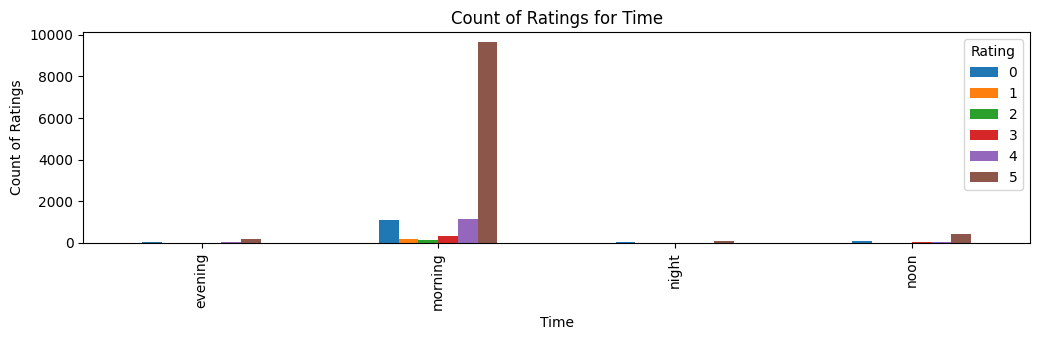

In [59]:
pivot_table = train.pivot_table(index='Time', columns='Rating', aggfunc='size', fill_value=0)
pivot_table.plot(kind='bar')
plt.xlabel('Time')
plt.ylabel('Count of Ratings')
plt.title('Count of Ratings for Time')
plt.show()

Most of the reviews are done in **Morning**,
From this we can say that users are more active in the platform at Mornings 

Cleaning Comments

In [60]:
def clean_text(text):
    cleaned_text = re.sub(r"[^a-zA-Z' ']","",text)
    return cleaned_text.lower()

Cleaning the **Recipe_Review** feature using **regex** removing special characters,converting the corpus into lower case.

In [61]:
train['cleaned_reviews'] = train['Recipe_Review'].apply(clean_text)
test['cleaned_reviews']=test['Recipe_Review'].apply(clean_text)

Sanity Check

In [62]:
train.isna().sum()

ID                   0
RecipeNumber         0
RecipeCode           0
RecipeName           0
CommentID            0
UserID               0
UserName             0
UserReputation       0
CreationTimestamp    0
ReplyCount           0
ThumbsUpCount        0
ThumbsDownCount      0
Rating               0
BestScore            0
Recipe_Review        0
Category             0
Time                 0
cleaned_reviews      0
dtype: int64

Changing recipe names,Time as numerical(Categorical->Numerical)

In [63]:
labelencoder=LabelEncoder()

In [64]:
train['Category']=labelencoder.fit_transform(train['Category'])
test['Category']=labelencoder.transform(test['Category'])

In [65]:
train['Time']=labelencoder.fit_transform(train['Time'])
test['Time']=labelencoder.transform(test['Time'])

In [66]:
model_data=train.drop(['ID','RecipeName','Recipe_Review','CommentID','UserID','UserName','CreationTimestamp'],axis=1)
test=test.drop(['ID','RecipeName','Recipe_Review','CommentID','UserID','UserName','CreationTimestamp'],axis=1)

Dropping unwanted columns which are of no use for the model

In [67]:
#TRAIN
y=model_data['Rating']
x=model_data.drop('Rating',axis=1)


In [68]:
#TEST
x_test=test

In [69]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.3,random_state=42,shuffle=True)

Splitting the dataset as train test split with **test size as 30%** of the orginal test data and **Shuffle=True**,**random_state=42**

In [70]:
#TRAIN
xtrain_numeric=xtrain.drop('cleaned_reviews',axis=1)
xtrain_txt=xtrain['cleaned_reviews']
xtest_numeric=xtest.drop('cleaned_reviews',axis=1)
xtest_txt=xtest['cleaned_reviews']

#TEST
x_test_numeric=x_test.drop('cleaned_reviews',axis=1)
x_test_txt=x_test['cleaned_reviews']

Splitting the data further as Numeric and Text

In [71]:
ss_columns=['Category','Time','RecipeNumber','RecipeCode', 'UserReputation', 'ReplyCount',
       'ThumbsUpCount', 'ThumbsDownCount', 'BestScore']
numeric_transformer=ColumnTransformer([('SS',StandardScaler(),ss_columns)])
numeric_transformer

ColumnTransformer(transformers=[('SS', StandardScaler(),
                                 ['Category', 'Time', 'RecipeNumber',
                                  'RecipeCode', 'UserReputation', 'ReplyCount',
                                  'ThumbsUpCount', 'ThumbsDownCount',
                                  'BestScore'])])

In [72]:
#TRAIN
xtrain_numeric_scaled=numeric_transformer.fit_transform(xtrain_numeric)
xtest_numeric_scaled=numeric_transformer.transform(xtest_numeric)
#TEST
x_test_numeric_scaled=numeric_transformer.transform(x_test_numeric)

![](https://journaldev.nyc3.cdn.digitaloceanspaces.com/2020/10/Standardization.png)

Applying **StandardScaler** on every numerical feature since it is less vulnerable to outliers

TFID-Vectorizer

In [73]:
stop_words = [
    "x", "y", "your", "yours", "yourself", "yourselves", "you", "yond", "yonder", "yon",
    "ye", "yet", "z", "zillion", "j", "u", "umpteen", "usually", "us", "username", "uponed",
    "upons", "uponing", "upon", "ups", "upping", "upped", "up", "unto", "until", "unless",
    "unlike", "unliker", "unlikest", "under", "underneath", "use", "used", "usedest", "r",
    "rath", "rather", "rathest", "rathe", "re", "relate", "related", "relatively", "regarding",
    "really", "res", "respecting", "respectively", "q", "quite", "que", "qua", "n", "neither",
    "neath", "neath", "nethe", "nethermost", "necessary", "necessariest", "necessarier", "never",
    "nevertheless", "nigh", "nighest", "nigher", "nine", "noone", "nobody", "nobodies", "nowhere",
    "nowheres", "no", "noes", "nor", "nos", "no-one", "none", "not", "notwithstanding", "nothings",
    "nothing", "nathless", "natheless", "t", "ten", "tills", "till", "tilled", "tilling", "to",
    "towards", "toward", "towardest", "towarder", "together", "too", "thy", "thyself", "thus",
    "than", "that", "those", "thou", "though", "thous", "thouses", "thoroughest", "thorougher",
    "thorough", "thoroughly", "thru", "thruer", "thruest", "thro", "through", "throughout",
    "throughest", "througher", "thine", "this", "thises", "they", "thee", "the", "then", "thence",
    "thenest", "thener", "them", "themselves", "these", "therer", "there", "thereby", "therest",
    "thereafter", "therein", "thereupon", "therefore", "their", "theirs", "thing", "things", "three",
    "two", "o", "oh", "owt", "owning", "owned", "own", "owns", "others", "other", "otherwise",
    "otherwisest", "otherwiser", "of", "often", "oftener", "oftenest", "off", "offs", "offest",
    "one", "ought", "oughts", "our", "ours", "ourselves", "ourself", "out", "outest", "outed",
    "outwith", "outs", "outside", "over", "overallest", "overaller", "overalls", "overall",
    "overs", "or", "orer", "orest", "on", "oneself", "onest", "ons", "onto", "a", "atween", "at",
    "athwart", "atop", "afore", "afterward", "afterwards", "after", "afterest", "afterer", "ain",
    "an", "any", "anything", "anybody", "anyone", "anyhow", "anywhere", "anent", "anear", "and",
    "andor", "another", "around", "ares", "are", "aest", "aer", "against", "again", "accordingly",
    "abaft", "abafter", "abaftest", "abovest", "above", "abover", "abouter", "aboutest", "about",
    "aid", "amidst", "amid", "among", "amongst", "apartest", "aparter", "apart", "appeared",
    "appears", "appear", "appearing", "appropriating", "appropriate", "appropriatest",
    "appropriates", "appropriater", "appropriated", "already", "always", "also", "along",
    "alongside", "although", "almost", "all", "allest", "aller", "allyou", "alls", "albeit",
    "awfully", "as", "aside", "asides", "aslant", "ases", "astrider", "astride", "astridest",
    "astraddlest", "astraddler", "astraddle", "availablest", "availabler", "available", "aughts",
    "aught", "vs", "v", "variousest", "variouser", "various", "via", "vis-a-vis", "vis-a-viser",
    "vis-a-visest", "viz", "very", "veriest", "verier", "versus", "k", "g", "go", "gone", "good",
    "got", "gotta", "gotten", "get", "gets", "getting", "b", "by", "byandby", "by-and-by", "bist",
    "both", "but", "buts", "be", "beyond", "because", "became", "becomes", "become", "becoming",
    "becomings", "becominger", "becomingest", "behind", "behinds", "before", "beforehand",
    "beforehandest", "beforehander", "bettered", "betters", "better", "bettering", "betwixt",
    "between", "beneath", "been", "below", "besides", "beside", "m", "my", "myself", "mucher",
    "muchest", "much", "must", "musts", "musths", "musth", "main", "make", "mayest", "many",
    "mauger", "maugre", "me", "meanwhiles", "meanwhile", "mostly", "most", "moreover", "more",
    "might", "mights", "midst", "midsts", "h", "huh", "humph", "he", "hers", "herself", "her",
    "hereby", "herein", "hereafters", "hereafter", "hereupon", "hence", "hadst", "had", "having",
    "haves", "have", "has", "hast", "hardly", "hae", "hath", "him", "himself", "hither", "hitherest",
    "hitherer", "his", "how-do-you-do", "however", "how", "howbeit", "howdoyoudo", "hoos", "hoo",
    "w", "woulded", "woulding", "would", "woulds", "was", "wast", "we", "wert", "were", "with",
    "withal", "without", "within", "why", "what", "whatever", "whateverer", "whateverest",
    "whatsoeverer", "whatsoeverest", "whatsoever", "whence", "whencesoever", "whenever", "whensoever",
    "when", "whenas", "whether", "wheen", "whereto", "whereupon", "wherever", "whereon", "whereof",
    "where", "whereby", "wherewithal", "wherewith", "whereinto", "wherein", "whereafter", "whereas",
    "wheresoever", "wherefrom", "which", "whichever", "whichsoever", "whilst", "while", "whiles",
    "whithersoever", "whither", "whoever", "whosoever", "whoso", "whose", "whomever", "s", "syne",
    "syn", "shalling", "shall", "shalled", "shalls", "shoulding", "should", "shoulded", "shoulds",
    "she", "sayyid", "sayid", "said", "saider", "saidest", "same", "samest", "sames", "samer",
    "saved", "sans", "sanses", "sanserifs", "sanserif", "so", "soer", "soest", "sobeit", "someone",
    "somebody", "somehow", "some", "somewhere", "somewhat", "something", "sometimest", "sometimes",
    "sometimer", "sometime", "several", "severaler", "severalest", "serious", "seriousest",
    "seriouser", "senza", "send", "sent", "seem", "seems", "seemed", "seemingest", "seeminger",
    "seemings", "seven", "summat", "sups", "sup", "supping", "supped", "such", "since", "sine",
    "sines", "sith", "six", "stop", "stopped", "p", "plaintiff", "plenty", "plenties", "please",
    "pleased", "pleases", "per", "perhaps", "particulars", "particularly", "particular",
    "particularest", "particularer", "pro", "providing", "provides", "provided", "provide",
    "probably", "l", "layabout", "layabouts", "latter", "latterest", "latterer", "latterly",
    "latters", "lots", "lotting", "lotted", "lot", "lest", "less", "ie", "ifs", "if", "i", "info",
    "information", "itself", "its", "it", "is", "idem", "idemer", "idemest", "immediate",
    "immediately", "immediatest", "immediater", "in", "inwards", "inwardest", "inwarder", "inward",
    "inasmuch", "into", "instead", "insofar", "indicates", "indicated", "indicate", "indicating",
    "indeed", "inc", "f", "fact", "facts", "fs", "figupon", "figupons", "figuponing", "figuponed",
    "few", "fewer", "fewest", "frae", "from", "failing", "failings", "five", "furthers", "furtherer",
    "furthered", "furtherest", "further", "furthering", "furthermore", "fourscore", "followthrough",
    "for", "forwhy", "fornenst", "formerly", "former", "formerer", "formerest", "formers", "forbye",
    "forby", "fore", "forever", "forer", "fores", "four", "d", "ddays", "dday", "do", "doing",
    "doings", "doe", "does", "doth", "downwarder", "downwardest", "downward", "downwards", "downs",
    "done", "doner", "dones", "donest", "dos", "dost", "did", "differentest", "differenter", "different",
    "describing", "describe", "describes", "described", "despiting", "despites", "despited", "despite",
    "during", "c", "cum", "circa", "chez", "cer", "certain", "certainest", "certainer", "cest",
    "canst", "cannot", "cant", "cants", "canting", "cantest", "canted", "co", "could", "couldst",
    "comeon", "comeons", "come-ons", "come-on", "concerning", "concerninger", "concerningest",
    "consequently", "considering", "e", "eg", "eight", "either", "even", "evens", "evenser",
    "evensest", "evened", "evenest", "ever", "everyone", "everything", "everybody", "everywhere",
    "every", "ere", "each", "et", "etc", "elsewhere", "else", "ex", "excepted", "excepts", "except",
    "excepting", "exes", "enough",'come', 'vis', 'viser', 'visest'
]


In [74]:
pipe_text=Pipeline([('TF-IDF',TfidfVectorizer(stop_words=stop_words,lowercase=True,max_features=1000))])

In [75]:
#TRAIN
xtrain_txt_vec=pipe_text.fit_transform(xtrain_txt)
xtest_txt_vec=pipe_text.transform(xtest_txt)
#TEST
x_test_txt_vec=pipe_text.transform(x_test_txt)

Applying TFID-Vectorizer on text feature by removing stop_words and setting max_features as 1000

In [76]:
xtrain_stacked=np.hstack([xtrain_numeric_scaled,xtrain_txt_vec.toarray()])
xtest_stacked=np.hstack([xtest_numeric_scaled,xtest_txt_vec.toarray()])
x_test_stacked=np.hstack([x_test_numeric_scaled,x_test_txt_vec.toarray()])

Stacking the numeric data and TFID-Vectorized data

**LogisticRegression**
From GridSearchCV found that 
'C': 100,
'penalty': 'l2',
'solver': 'sag',
'tol': 0.001}
these are the best parameters

In [77]:
logisticregression=LogisticRegression(max_iter=1000,warm_start=True,random_state=47,C=100,penalty='l2',solver='sag',tol=0.001)
logisticregression.fit(xtrain_stacked,ytrain)
logisticregression.score(xtest_stacked,ytest)

0.7753605475433879

 Loss Function for LogisticRegression
 
**LogLoss=1/n sum(-(y*log(p) + (1-y)*log(1-p)))**



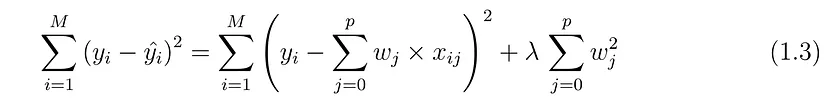

**Cost Function For Ridge**

In [78]:
ypredtrainLR=logisticregression.predict(xtrain_stacked)
ypredtestLR=logisticregression.predict(xtest_stacked)
print('Train:',accuracy_score(ytrain,ypredtrainLR))
print('Test:',accuracy_score(ytest,ypredtestLR))

Train: 0.7975479408990883
Test: 0.7753605475433879


In [79]:
target_names=['0','1','2','3','4','5']
print('Logistic Regression \n',classification_report(ytest,ypredtestLR,target_names=target_names))

Logistic Regression 
               precision    recall  f1-score   support

           0       0.48      0.16      0.24       369
           1       0.57      0.07      0.12        61
           2       0.50      0.06      0.11        48
           3       0.39      0.10      0.16       108
           4       0.39      0.11      0.17       396
           5       0.80      0.98      0.88      3109

    accuracy                           0.78      4091
   macro avg       0.52      0.25      0.28      4091
weighted avg       0.71      0.78      0.72      4091



DecisionTreeClassifier

In [80]:
from sklearn.tree import DecisionTreeClassifier
DTC=DecisionTreeClassifier()
DTC.fit(xtrain_stacked,ytrain)
DTC.score(xtest_stacked,ytest)

0.6546076753849914

![](https://d14b9ctw0m6fid.cloudfront.net/ugblog/wp-content/uploads/2020/10/19.png)

Gini index formula

Decision Trees uses the typical loss function **L=(y−y^)2**


In [81]:
ypredtrainDTC=DTC.predict(xtrain_stacked)
ypredtestDTC=DTC.predict(xtest_stacked)
print('Train:',accuracy_score(ytrain,ypredtrainDTC))
print('Test:',accuracy_score(ytest,ypredtestDTC))

Train: 0.9987425337944043
Test: 0.6546076753849914


In [82]:
target_names=['0','1','2','3','4','5']
print('DecisionTreeClassifier\n',classification_report(ytest,ypredtestDTC,target_names=target_names))

DecisionTreeClassifier
               precision    recall  f1-score   support

           0       0.22      0.23      0.23       369
           1       0.23      0.15      0.18        61
           2       0.07      0.06      0.07        48
           3       0.11      0.13      0.12       108
           4       0.17      0.17      0.17       396
           5       0.81      0.80      0.81      3109

    accuracy                           0.65      4091
   macro avg       0.27      0.26      0.26      4091
weighted avg       0.66      0.65      0.66      4091



Post Pruning

In [83]:
path = DTC.cost_complexity_pruning_path(xtrain_stacked, ytrain)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [84]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(xtrain_stacked, ytrain)
    clfs.append(clf)

In [ ]:
train_scores = [clf.score(xtrain_stacked, ytrain) for clf in clfs]
test_scores = [clf.score(xtest_stacked, ytest) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [ ]:
DTC=DecisionTreeClassifier(ccp_alpha=0.0005)
DTC.fit(xtrain_stacked,ytrain)
DTC.score(xtest_stacked,ytest)

RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RFC=RandomForestClassifier(max_depth=250)
RFC.fit(xtrain_stacked,ytrain)
RFC.score(xtest_stacked,ytest)

In [ ]:
from sklearn.metrics import accuracy_score
ypredtrainRFC=RFC.predict(xtrain_stacked)
ypredtestRFC=RFC.predict(xtest_stacked)
print('Train:',accuracy_score(ytrain,ypredtrainRFC))
print('Test:',accuracy_score(ytest,ypredtestRFC))

In [ ]:
target_names=['0','1','2','3','4','5']
print('RandomForestClassifier\n',classification_report(ytest,ypredtestRFC,target_names=target_names))

In [ ]:
parameter_range=np.arange(10,100,10)
train_score, test_score = validation_curve(RandomForestClassifier(), xtrain_stacked, ytrain,
                                           param_name="min_samples_split",
                                           param_range=parameter_range,
                                           cv=5, scoring="accuracy")

In [ ]:
mean_train_score = np.mean(train_score, axis=1)
std_train_score = np.std(train_score, axis=1)

mean_test_score = np.mean(test_score, axis=1)
std_test_score = np.std(test_score, axis=1)

plt.plot(parameter_range, mean_train_score,
         label="Training Score", color='b')
plt.plot(parameter_range, mean_test_score,
         label="Test Score", color='g')

plt.title("Validation Curve for RandomForestClassifier")
plt.xlabel("Max Depth of the Tree")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc='best')
plt.show()

StackingClassifier

![](https://miro.medium.com/v2/resize:fit:1400/1*-4VerxoDZVYb9MxJ1Eee7w.png)

In [ ]:
from sklearn.ensemble import StackingClassifier
estimator=[('DT',DecisionTreeClassifier(max_depth=5)),
           ('RFC',RandomForestClassifier(max_depth=250))]
final_estimator=LogisticRegression(max_iter=1000,warm_start=True,random_state=47,C=100,penalty='l2',solver='sag',tol=0.001)
SC=StackingClassifier(estimator,final_estimator=final_estimator,passthrough=True)

In [ ]:
SC.fit(xtrain_stacked,ytrain)
SC.score(xtest_stacked,ytest)

In [ ]:
from sklearn.metrics import accuracy_score
ypredtrainSC=SC.predict(xtrain_stacked)
ypredtestSC=SC.predict(xtest_stacked)
print('Train:',accuracy_score(ytrain,ypredtrainSC))
print('Test:',accuracy_score(ytest,ypredtestSC))

# SUBMISSION

In [ ]:
y_pred = SC.predict(x_test_stacked) 
submission = pd.DataFrame({"ID": np.arange(1,len(y_pred)+1),
                           "total_amount": y_pred})

submission.to_csv('submission.csv',index=False)